In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import math
import mysql.connector

mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "",
    database ='etl'
)
 
# Creating an instance of 'cursor' class
# which is used to execute the 'SQL'
# statements in 'Python'
cursor = mydb.cursor()
 
# Show database tables
cursor.execute("SHOW TABLES")
 
for x in cursor:
  print(x)

def sql_upload(pd_dataframe):
    for index, row in pd_dataframe.iterrows():
        cursor.execute("INSERT INTO bitcoin (unix,date,symbol,open,high,low,close,Volume_BTC,Volume_USD) values(%s,%s,%s,%s,%s,%s,%s,%s,%s)",(row['unix'],row['date'],row['symbol'],row['open'],row['high'],row['low'],row['close'],row['Volume BTC'],row['Volume USD']))
        mydb.commit()
    print("Successfully uploaded to sql table")
    
    
#df = pd.read_csv('csv/BTC-Daily.csv')
#df

('bitcoin',)
('crypto',)
('newcrypto',)
('newcrypto1',)


In [71]:
#Uploading to SQL 
#sql_upload(df)

In [116]:
df = pd.read_sql("SELECT * from bitcoin", con=mydb)
df

,unix,date,symbol,open,high,low,close,Volume_BTC,Volume_USD
0,1417132800,2014-11-28,BTC/USD,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
1,1417219200,2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2,1417305600,2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3,1417392000,2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
4,1417478400,2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...,...,...
2646,1645747200,2022-02-25,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
2647,1645833600,2022-02-26,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
2648,1645920000,2022-02-27,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
2649,1646006400,2022-02-28,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08


# **Preprosessing**

In [117]:
#df = pd.read_csv('/kaggle/input/btcinusd/BTC-Daily.csv')
# Removing all unessesary columns ( See Research )
df = df = df.drop(["Volume_BTC", "unix","Volume_USD", "symbol"], axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.index = df.pop("date")
df

,open,high,low,close
date,,,,
2014-11-28,363.59,381.34,360.57,376.28
2014-11-29,376.42,386.60,372.25,376.72
2014-11-30,376.57,381.99,373.32,373.34
2014-12-01,376.40,382.31,373.03,378.39
2014-12-02,378.39,382.86,375.23,379.25
...,...,...,...,...
2022-02-25,38360.93,39727.97,38027.61,39231.64
2022-02-26,39242.64,40330.99,38600.00,39146.66
2022-02-27,39146.66,39886.92,37015.74,37712.68


# **Standardization**

In [118]:
# Scaler for N-Dimensional Array
df_features = df.drop(['close'],axis=1)
df_np = df_features.to_numpy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_np, (-1,1))
df_scaled[0]

array([0.00299159, 0.00244959, 0.00314943])

In [119]:
# Scaler for 1D array
df_close = pd.DataFrame(df['close'])
df_close_np = df_close.to_numpy()
to_inverse_scale = MinMaxScaler()
df_close_scale = to_inverse_scale.fit_transform(df_close_np)
df_close_scale

array([[0.00317937],
       [0.0031859 ],
       [0.00313575],
       ...,
       [0.55715655],
       [0.63826253],
       [0.63835898]])

# **Converting Data to 3 Dimensions **

In [120]:
x = [] # The features needed for prediction.
y = [] # The expected result.

for i in range(len(df_scaled)-6):
    x.append(df_scaled[i:i+6])

for i in range(len(df_close_scale)-1):
        y.append(df_close_scale[i][0])


# Converting to Numpy array for easier reading by the ML-Algorithm
X = np.array(x)
Y = np.array(y)




# **Splitting the Data (Train/Test)**

In [121]:
train_no = math.floor(len(X) * 0.7) # 70% for training, 30% For Testing
total_no = len(X) 
X_Train, Y_Train = X[:train_no][:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

In [122]:
print(X_Train.shape, Y_Train.shape)
print(X_Test.shape, Y_Test.shape)

(1851, 6, 3) (1851,)
(793, 6, 3) (793,)


In [123]:
X_Train, Y_Train = X[:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

# **Developing The Model**

In [124]:
model = Sequential()
# Three layers, Final Output is in an array of 10 predictions
model.add(LSTM(50, return_sequences=True, input_shape=(6,3)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(15))
model.add(Dense(1))
          

In [125]:
model.compile(optimizer='adam', loss='mean_squared_error') # Compling the Model

In [126]:
modeled = model.fit(X_Train, Y_Train, batch_size=1, epochs=10) # Training the model

Epoch 1/10
1851/1851 [==============================] - 16s 7ms/step - loss: 1.1356e-04
Epoch 2/10
1851/1851 [==============================] - 12s 7ms/step - loss: 4.9446e-05
Epoch 3/10
1851/1851 [==============================] - 12s 7ms/step - loss: 4.7327e-05
Epoch 4/10
1851/1851 [==============================] - 13s 7ms/step - loss: 4.1611e-05
Epoch 5/10
1851/1851 [==============================] - 13s 7ms/step - loss: 4.1180e-05
Epoch 6/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.4437e-05
Epoch 7/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.5036e-05
Epoch 8/10
1851/1851 [==============================] - 13s 7ms/step - loss: 2.9739e-05
Epoch 9/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.2632e-05
Epoch 10/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.1469e-05


# **Testing the Model**

In [127]:
predictions = model.predict(X_Test)
predictions = to_inverse_scale.inverse_transform(predictions) # Reverse the standardization.


25/25 [==============================] - 1s 5ms/step


In [146]:
# Putting the predictions in an array to convert into dataframe column later.
valid = []
for i in range(len(predictions)):
    valid.append(predictions[i][0]) # Using the final prediction in the array.
    

# **Validating the Results**

In [147]:
new_df = pd.DataFrame(df[train_no: total_no - 1])

new_df = new_df.drop(["high","low","open"], axis=1)

new_df['Prediction'] = valid


new_df

,close,Prediction
date,,
2019-12-23,7316.17,7234.145020
2019-12-24,7251.52,7143.674316
2019-12-25,7195.79,7126.168457
2019-12-26,7188.30,7148.005859
2019-12-27,7246.00,7151.808105
...,...,...
2022-02-18,39996.99,33183.507812
2022-02-19,40109.02,33001.566406
2022-02-20,38373.90,32760.695312


In [159]:
#new_df.plot()
first = new_df.iloc[2020-11-14]
first

IndexError: single positional indexer is out-of-bounds

In [149]:
new_df.corr() # Accuracy around 99.5%

,close,Prediction
close,1.000000,0.966416
Prediction,0.966416,1.000000


In [47]:
X_Test

array([[[1.33408365e-01, 1.32996476e-01],
        [6.78351801e-07, 6.59069005e-07],
        [1.06377896e-06, 1.04486550e-06],
        [3.02683657e-04, 2.95375438e-04],
        [8.87947090e-04, 8.83184616e-04],
        [1.58179306e-05, 1.60909286e-05]],

       [[6.78351801e-07, 6.59069005e-07],
        [1.06377896e-06, 1.04486550e-06],
        [3.02683657e-04, 2.95375438e-04],
        [8.87947090e-04, 8.83184616e-04],
        [1.58179306e-05, 1.60909286e-05],
        [2.81404994e-03, 2.81626616e-03]],

       [[1.06377896e-06, 1.04486550e-06],
        [3.02683657e-04, 2.95375438e-04],
        [8.87947090e-04, 8.83184616e-04],
        [1.58179306e-05, 1.60909286e-05],
        [2.81404994e-03, 2.81626616e-03],
        [1.58641819e-05, 1.61391532e-05]],

       ...,

       [[3.73093490e-06, 3.69721637e-06],
        [2.20007989e-03, 2.18497450e-03],
        [3.61730327e-02, 3.53312265e-02],
        [5.39258847e-04, 5.29344935e-04],
        [5.40192136e-01, 5.40113737e-01],
        [1.5432

In [151]:
test = X_Test[787:]

tests = model.predict(test)
tests =to_inverse_scale.inverse_transform(tests)
t = []
for i in range(len(tests)):
    t.append(tests[i][0])

t

1/1 [==============================] - 0s 17ms/step


[33648.906, 33183.508, 33001.566, 32760.695, 32494.771, 32413.994]

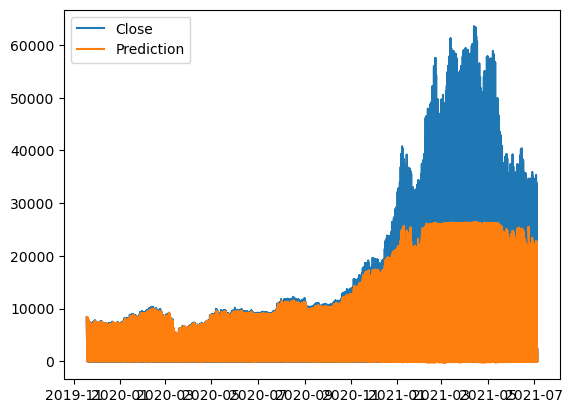

In [27]:
import matplotlib.pyplot as plt
plt.plot(new_df['Close'])
plt.plot(new_df['Prediction'])
plt.legend(["Close","Prediction"])
plt.show()

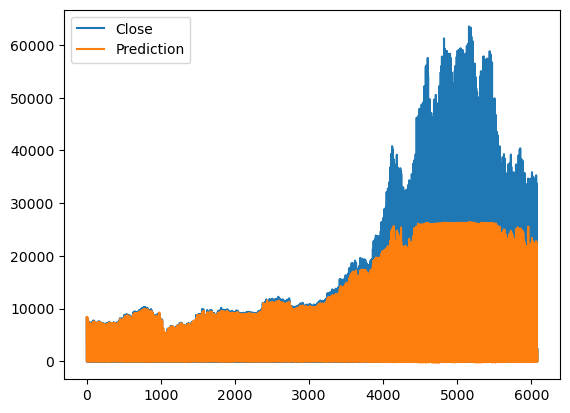

In [28]:
import matplotlib.pyplot as plt

close = new_df['Close'].to_numpy()
predict = new_df['Prediction'].to_numpy()

plt.plot(close)
plt.plot(predict)

plt.legend(["Close","Prediction"])
plt.show()

<AxesSubplot:xlabel='Date'>

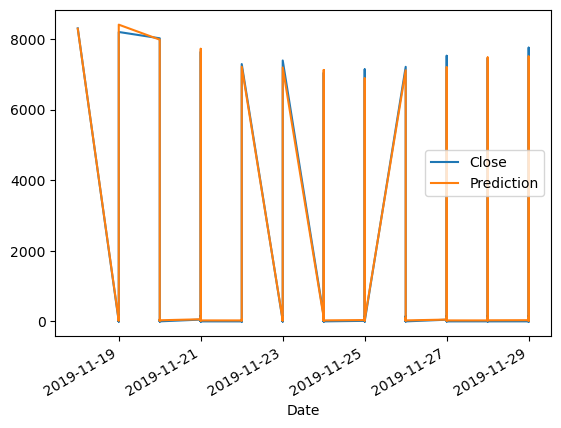

In [29]:
test_df=new_df.head(100)
test_df.plot()

In [42]:
#import joblib
#import pickle
import keras

In [31]:
#filename = "Completed_model.joblib"
#joblib.dump(model, filename)

INFO:tensorflow:Assets written to: ram://087a8841-7afd-41ee-b44e-33cacab26ebf/assets


INFO:tensorflow:Assets written to: ram://087a8841-7afd-41ee-b44e-33cacab26ebf/assets


['Completed_model.joblib']

In [39]:
#loaded_model = joblib.load(r"C:\Users\Lionel Jr\Downloads\SEPB-GoCrypt-Backend-Bernard-LSTM-Base\ML-Algorithms\Completed_model.joblib")
#result = loaded_model.score(X_test, y_test)
#print(result)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://06ded6e2-54c4-4df8-96e6-c469de181a3e/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [35]:
#with open('model_pkl', 'wb') as files:
    #pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://16fe4280-5b06-4ea6-9de9-f1324cba49f9/assets


INFO:tensorflow:Assets written to: ram://16fe4280-5b06-4ea6-9de9-f1324cba49f9/assets


In [36]:
# load saved model
#with open('model_pkl' , 'rb') as f:
#    lr = pickle.load(f)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://005e8f9d-592c-4df3-b7bb-4de4fe18e19e/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [40]:
model.save('SEPB_Model_BTC')

INFO:tensorflow:Assets written to: SEPB_Model\assets


INFO:tensorflow:Assets written to: SEPB_Model\assets


In [43]:
reconstruct_model=keras.models.load_model("SEPB_Model")

In [44]:
reconstruct_model

In [46]:
tests = reconstruct_model.predict(test)
tests =to_inverse_scale.inverse_transform(tests)
t = []
for i in range(len(tests)):
    t.append(tests[i][9])

t

166/166 [==============================] - 2s 3ms/step


[68.07362,
 28.913914,
 31.99688,
 36.1127,
 46.355186,
 9903.463,
 41.50174,
 71.7324,
 35.515602,
 46.056637,
 9801.482,
 28.9811,
 32.516857,
 36.679996,
 199.30638,
 9599.584,
 27.508223,
 27.671928,
 28.531618,
 166.74222,
 65.01857,
 28.070782,
 39.255756,
 28.972584,
 165.19269,
 27.534245,
 38.576805,
 27.863075,
 64.701096,
 34.182774,
 38.96572,
 59.574177,
 9889.385,
 9608.777,
 27.883894,
 27.478415,
 28.292685,
 64.9547,
 28.601643,
 175.26012,
 27.476995,
 39.010197,
 27.88484,
 27.18649,
 40.216698,
 31.830334,
 35.341015,
 46.09922,
 9613.856,
 66.01926,
 174.92514,
 28.57562,
 166.31403,
 28.193325,
 62.15467,
 39.46299,
 31.674198,
 35.698708,
 46.658466,
 9315.494,
 31.695963,
 35.75359,
 47.10511,
 9388.135,
 28.229757,
 169.0942,
 32.31672,
 46.288002,
 83.96679,
 9383.841,
 27.529512,
 28.2061,
 39.412365,
 169.50865,
 27.441982,
 27.77034,
 64.85723,
 27.88342,
 67.43536,
 32.236286,
 35.8028,
 46.446976,
 9517.951,
 27.618464,
 38.713066,
 28.626719,
 172.60297,

In [48]:
tests

array([[  83.78605 ,   73.464554,   97.03816 , ...,   85.59864 ,
         105.943085,   68.07362 ],
       [  44.654728,   34.410355,   57.894066, ...,   45.9833  ,
          67.10038 ,   28.913914],
       [  47.754726,   37.51272 ,   60.985077, ...,   49.069576,
          70.242485,   31.99688 ],
       ...,
       [  61.79745 ,   51.543613,   74.91141 , ...,   63.10426 ,
          84.431885,   45.909966],
       [ 144.26392 ,  133.92207 ,  157.07697 , ...,  146.06421 ,
         167.01521 ,  128.05518 ],
       [2012.7142  , 2004.0573  , 2021.8325  , ..., 2018.8418  ,
        2029.0781  , 1999.1144  ]], dtype=float32)